## Predicting Salary of a job position based on various attributes

<h3>Importing libraries</h3>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from functions import *
from data_preparation import *
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics

In [2]:
%matplotlib inline

<h3>Importing the dataset

In [3]:
dataset = pd.read_csv("Salaries.csv")

<h3>Exploratory Analysis</h3>

In [4]:
dataset.columns

Index(['Job code', 'Company', 'Experience', 'Distance', 'Highest Degree',
       'Major Subject', 'Designation ', 'Domain', 'Salary'],
      dtype='object')

<h3> Treating column names </h3> <br>
**Some columns like 'Job code', 'Highest Degree' have spaces in between and "Designation ' has a space in the end. These initial data handling errors should be corrected to avoid problems while referring to columns and allow easy access. Therefore we need to remove unnecessary spaces from columns names<br> We can also use underscores, I am choosing to replace them with an empty string**

In [5]:
dataset.columns = dataset.columns.str.replace('\s+', '')  # in case there are multiple white spaces

In [6]:
dataset.columns

Index(['Jobcode', 'Company', 'Experience', 'Distance', 'HighestDegree',
       'MajorSubject', 'Designation', 'Domain', 'Salary'],
      dtype='object')

In [7]:
dataset.shape

(1000000, 9)

**We have 6 string (object) columns and 3 continuous int columns<br>Also we do not have anu missing values**

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
Jobcode          1000000 non-null object
Company          1000000 non-null object
Experience       1000000 non-null int64
Distance         1000000 non-null int64
HighestDegree    1000000 non-null object
MajorSubject     1000000 non-null object
Designation      1000000 non-null object
Domain           1000000 non-null object
Salary           1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


<h3> Instantiating the functions class</h3><br>
**It contains pre analysis function - we will use methods defined in the class**

In [9]:
f = functions()

<h3>Further evaluating string columns - Checking the unique values in each

In [10]:
f.string_col_count('Company', dataset)
f.string_col_count('HighestDegree', dataset)
f.string_col_count('MajorSubject', dataset)
f.string_col_count('Designation', dataset)

Company has 63 unique values
HighestDegree has 5 unique values
MajorSubject has 9 unique values
Designation has 8 unique values


<h3> Checking the distribution of each column </h3> <br>
* **Highest degree is almost uniformly distributed, None is value which can be dealt with in different ways but we will keep it as is for now**<br>
* **Major Subject is almost perfectly uniformly distributed except for None which is extremely high but we would keep it for now**
* **Designation is almost perfectly uniformly distributed**
* **Domain is almost perfectly uniformly distributed**

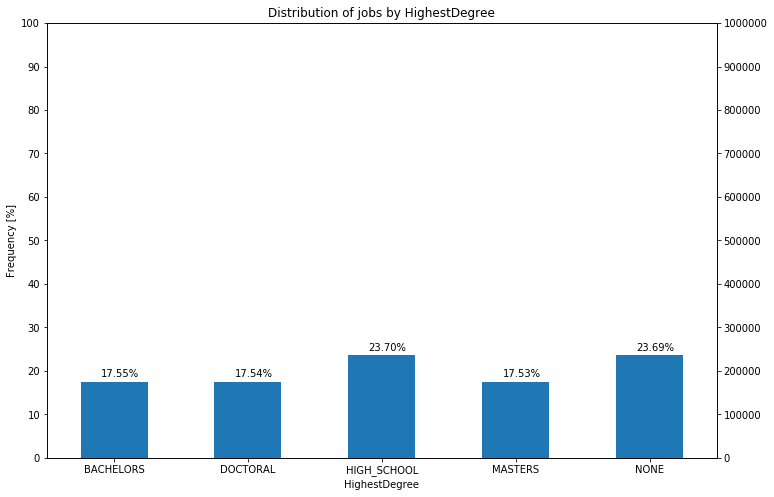

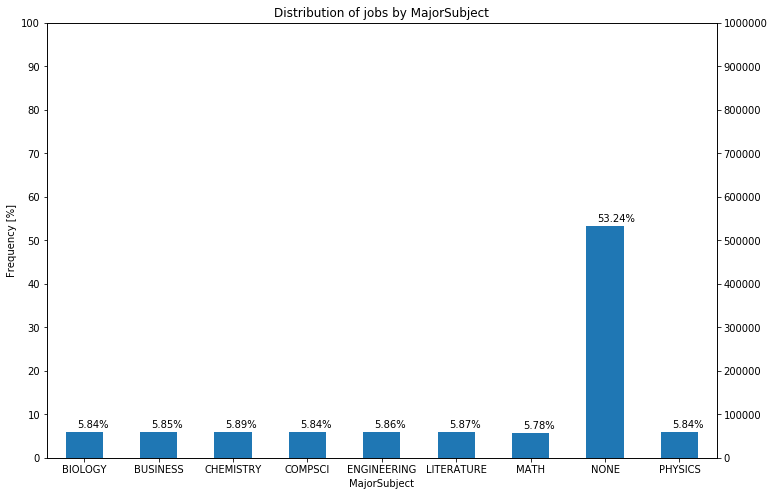

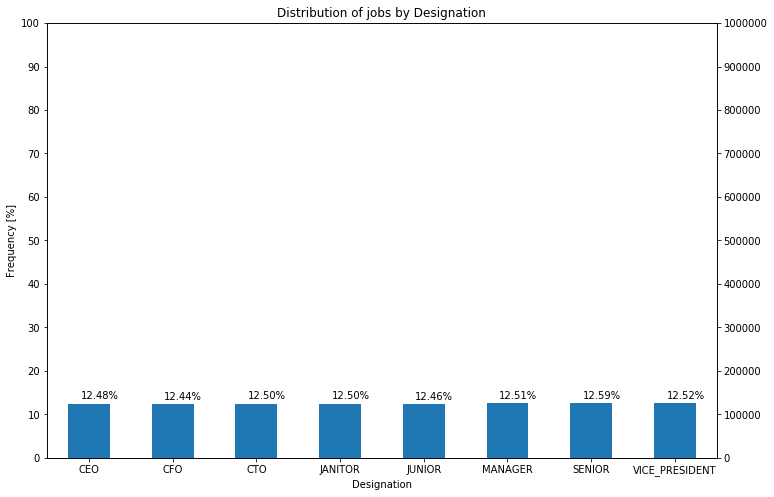

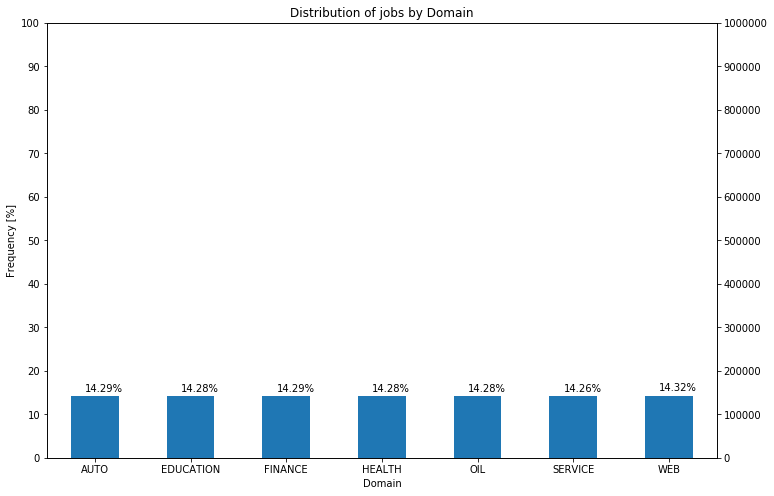

In [11]:
f.check_distribution('HighestDegree', dataset)
f.check_distribution('MajorSubject', dataset)
f.check_distribution('Designation', dataset)
f.check_distribution('Domain', dataset)

<h3>Boxplot Analysis </h3><br>

* **Salaries are highest in Engineering and Computer Science and are lowest in the field of literature**
* **Doctoral holders earn the highest followed by masters**
* **Top earning designations are chief executives, finance and technology officers followed by the vice presidents**
* **Finance and oil are the highest earning domains followed by healthcare with education being the lowest**


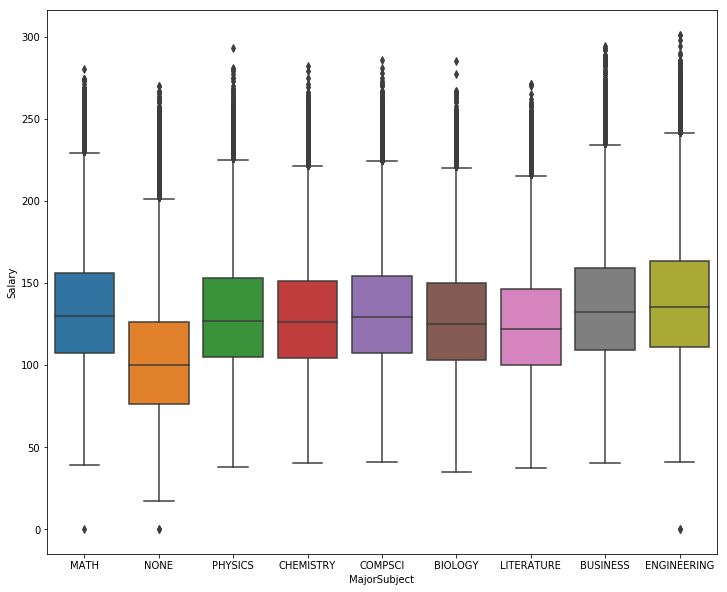

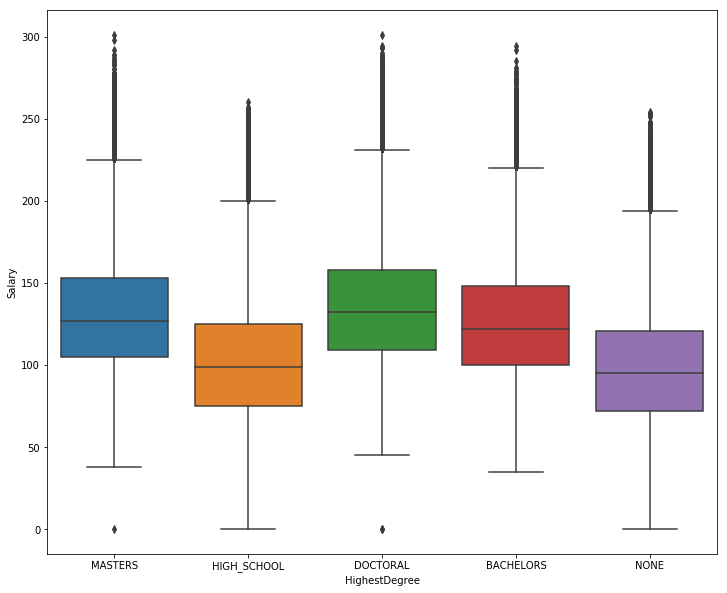

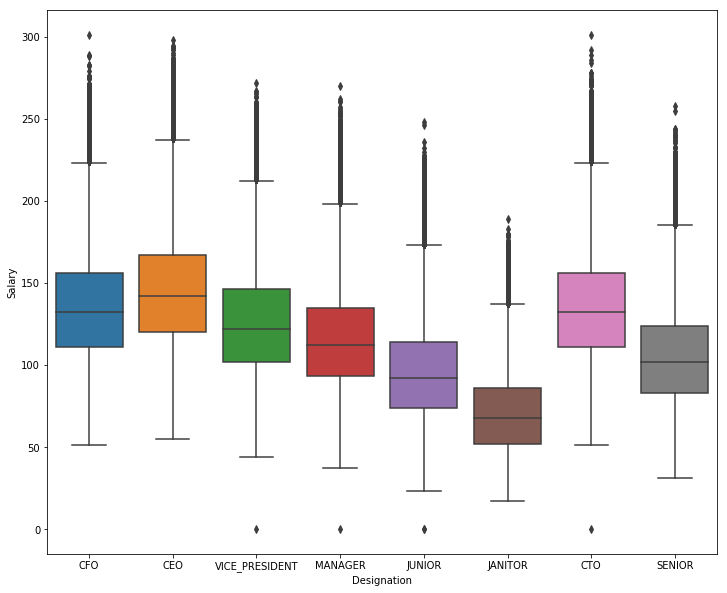

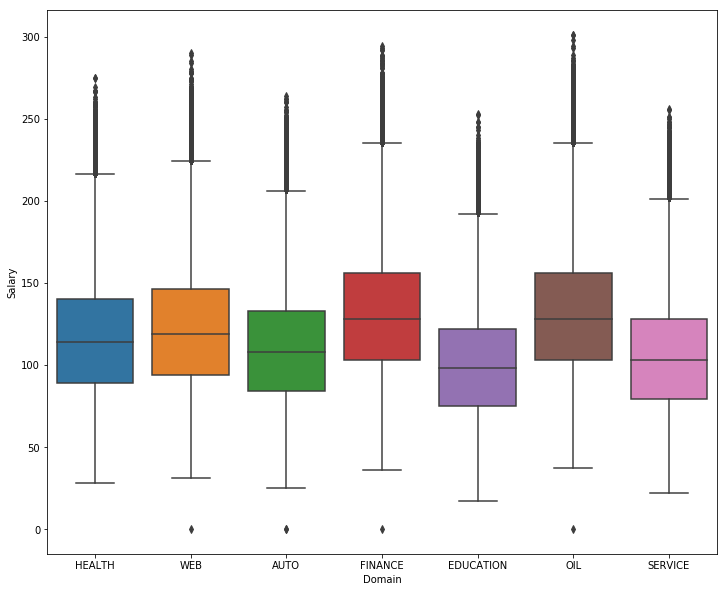

In [12]:
f.check_boxplot("MajorSubject", "Salary", dataset)
f.check_boxplot("HighestDegree", "Salary", dataset)
f.check_boxplot("Designation", "Salary", dataset)
f.check_boxplot("Domain", "Salary", dataset)

<h3>Exploring continuous variables </h3> <br>
* **Experience has a 38% positive correlation with Salary**
* **Distance has a negative 30% correlation with salary**

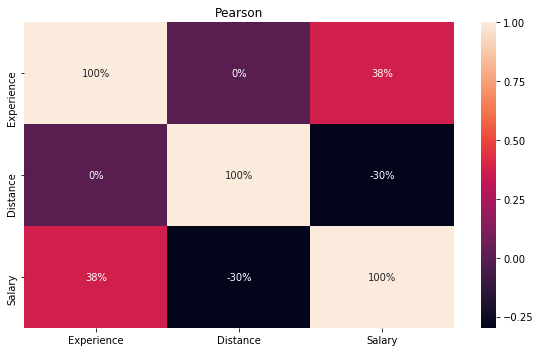

In [13]:
continuous_only = dataset[['Experience', 'Distance', 'Salary']]
f.create_corrmap(continuous_only)

In [14]:
dataset.describe()

,Experience,Distance,Salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


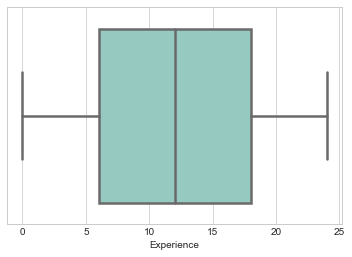

In [15]:
sns.set_style("whitegrid")
ax = sns.boxplot(x=dataset.Experience, palette="Set3", linewidth=2.5)

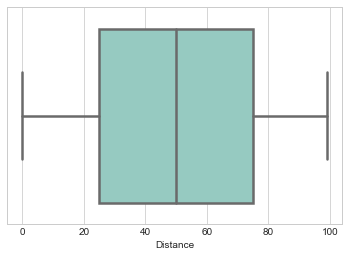

In [16]:
sns.set_style("whitegrid")
ax = sns.boxplot(x=dataset.Distance, palette="Set3", linewidth=2.5)

<h3> Instantiating the data preparation class </h3><br>
** This class has methods that help clean and treat the data **


In [17]:
dp = data_preparation()
dir(dp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'create_dummies',
 'drop_high_levels',
 'drop_nan_col',
 'drop_zero_car_col',
 'drop_zero_var_col',
 'encode_target',
 'replace_missing']

<h2> The algorithm we would be using for this is  - XGBOOST </h2>

<h3>What is XGBOOST?</h3><br>
* **XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting”. XGBoost is used for supervised learning problems, where we use the training data to predict a target variable**
* **It is the most powerful implementation of gradient boost and one of the most popular and powerful algorithm**
* **Boosting is not a ML algo by itself rather it is a concept that can be applied to a set of ML algorithms**
* **Boosting converts multiple weak learners into a strong learner (An algo that can be tuned to achieve good performance). A weak leaner is an ML algorithm that is slightly better than chance**

<h3>What are its advantages?</h3><br>
* **XGboost is popular because of its speed and performance, core algorithm is parallelizable**

<h3>How is boosting accomplished</h3><br>
** Boosting converts multiple weak learners into a strong learner (An algo that can be tuned to achieve good performance). A weak leaner is an ML algorithm that is slightly better than chance.** <br>
* **Iteratively learning a set of weak models on subsets of data**
* **Weighting each weak prediction according to each weak learner’s performance**
* **Combine the weighted predictions to obtain a single weighted prediction**

**NOTE - XGBoost converts the data into a dmatrix (its own optimized data structure) datatype for better performance, this is done on the fly, however, if we do cross validation we need to explicitly convert the data into d matrix**


<h3>Feature Engineering


<h3>drop_nan_col()</h3><br>**This method allows us to choose and threshold and remove all columns that missing values more than that threshold**

In [18]:
dp.drop_nan_col(dataset, 0.9)

Jobcode does not have more than 90.0  % missing values
Company does not have more than 90.0  % missing values
Experience does not have more than 90.0  % missing values
Distance does not have more than 90.0  % missing values
HighestDegree does not have more than 90.0  % missing values
MajorSubject does not have more than 90.0  % missing values
Designation does not have more than 90.0  % missing values
Domain does not have more than 90.0  % missing values
Salary does not have more than 90.0  % missing values


,Jobcode,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,JOB1362684407687,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,JOB1362684407688,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,JOB1362684407689,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,JOB1362684407690,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,JOB1362684407691,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163


<h3>drop_zero_var_col()</h3><br>
**This method removes all columns that have zero variance**

In [19]:
dp.drop_zero_var_col(dataset)

Experience does not have 0 variance - KEEP IT
Distance does not have 0 variance - KEEP IT
Salary does not have 0 variance - KEEP IT


,Jobcode,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,JOB1362684407687,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,JOB1362684407688,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,JOB1362684407689,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,JOB1362684407690,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,JOB1362684407691,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163


<h3>drop_high_levels()</h3><br>
**This method allows us to choose a threshold and removes columns that have more than the threshold unique values in the column**

In [20]:
dp.drop_high_levels(dataset, 100)

Column Jobcode has levels more than 100 levels hence it has been removed


,Company,Experience,Distance,HighestDegree,MajorSubject,Designation,Domain,Salary
0,C37,10,83,MASTERS,MATH,CFO,HEALTH,130
1,C19,3,73,HIGH_SCHOOL,NONE,CEO,WEB,101
2,C52,10,38,DOCTORAL,PHYSICS,VICE_PRESIDENT,HEALTH,137
3,C38,8,17,DOCTORAL,CHEMISTRY,MANAGER,AUTO,142
4,C7,8,16,BACHELORS,PHYSICS,VICE_PRESIDENT,FINANCE,163


<h3>How to treat numerical and categorical data?</h3><br>
**Xgboost manages only numeric vectors, hence we need to convert categorical to numerical. We will do that using the**
**create_dummies() - This method creates dummies with an option to avoid dummy variable trap**

In [21]:
dataset = dp.create_dummies(dataset, 'Salary', False)

<h3>We have a cleaned dataframe, let explore its attributes</h3>

In [22]:
dataset.shape

(1000000, 95)

In [23]:
dataset.head()

,Experience,Distance,Company_C0,Company_C1,Company_C10,Company_C11,Company_C12,Company_C13,Company_C14,Company_C15,...,Designation_SENIOR,Designation_VICE_PRESIDENT,Domain_AUTO,Domain_EDUCATION,Domain_FINANCE,Domain_HEALTH,Domain_OIL,Domain_SERVICE,Domain_WEB,Salary
0,10,83,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,130
1,3,73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,101
2,10,38,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,137
3,8,17,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,142
4,8,16,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,163


<h3>Converting the dataset into train and test</h3>

In [25]:
y = dataset.Salary.values
del dataset['Salary']
X = dataset.values


In [29]:
y.reshape(1000000,1)

array([[130],
       [101],
       [137],
       ..., 
       [ 64],
       [149],
       [ 88]], dtype=int64)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

<h3>How is data stored in XGboost?</h3><br>
**Data in XGBoost is stored as a DMatrix object. This can be simply created by calling the DMatrix method of the XGBoost model instance.**

In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [46]:
param = {
    'n_estimators' : 50,
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'reg:linear',
    'eval_metric': 'rmse'
}
# error evaluation for multiclass training
num_round = 20  # the number of training iterations

In [47]:
bst = xgb.train(param, dtrain, num_round)

In [48]:
preds = bst.predict(dtest)

In [54]:
sklearn.metrics.mean_absolute_error(y_test, preds)

15.576945828305563

In [ ]:
<h1> More work to come...</h1>